<a href="https://colab.research.google.com/github/vchandraiitk/datascience/blob/main/Vikas_M6_NB_MiniProject_4_Urban_Traffic_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Urban Traffic Flow Prediction using Graph Convolution Network - LSTM

## Learning Objectives

At the end of the Mini Project, you will be able to :

* forecast traffic flow using Graph Convolutional Network and LSTM
* understand the graph structured data and implement the forecasting model

## Information

Accurate and real-time traffic forecasting plays an important role in the Intelligent Traffic System and is important for

- urban traffic planning,
- traffic management, and
- traffic control.

Traffic forecasting is a challenging issue because of the constraints of the urban road network topological structure and the law of dynamic change with time (spatial dependence and temporal dependence). To capture the spatial and temporal dependence simultaneously, a neural network-based traffic forecasting method called the temporal graph convolutional network (T-GCN) model is very useful. It is a combination of the graph convolutional network (GCN) and gated recurrent unit (GRU).

- Specifically, the GCN is used to learn complex topological structures to capture spatial dependence and the gated recurrent unit is used to learn dynamic changes of traffic data to capture temporal dependence. Then, the T-GCN model is employed to traffic forecasting based on the urban road network. T-GCN model can obtain the spatio-temporal correlation from traffic data and the predictions outperform state-of-art baselines on real-world traffic datasets.

Reference: https://arxiv.org/abs/1811.05320

## Dataset



Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning.

This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). This dataset contains traffic speeds from Mar-1 to Mar-7, 2012 of 207 sensors, recorded every 5 minutes.  There are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes. This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207 for 7 days (12X24X7).

Data Source:
https://github.com/lehaifeng/T-GCN/tree/master/data

## Problem Statement

#### Forecasting urban traffic flow using spatio-temporal data with combined Graph Convolution + LSTM model

## Grading = 10 Points

In [49]:
#@title Download dataset
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_adj.csv
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_speed.csv
!pip -qq install chardet
!pip -qq install git+https://github.com/VenkateshwaranB/stellargraph.git

  Preparing metadata (setup.py) ... done


### Import required packages

In [50]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
import stellargraph as sg
from stellargraph.layer import GCN
from stellargraph.layer import GCN_LSTM
import networkx as nx

### Data loading and preparation ( 2 points)

In [51]:
adj_path = "/content/los_adj.csv"
speed_data_path= "/content/los_speed.csv"

In [52]:
# YOUR CODE HERE
df_adj = pd.read_csv(adj_path, header=None)
df_adj.head()

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.119804,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.000000,0.717438,0.000000,0.000000,0.000000,0.000000,0.390457,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.717438,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,1.000000,0.633722,0.894812,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.633722,1.000000,0.361432,0.135197,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# YOUR CODE HERE
df_speed = pd.read_csv(speed_data_path)

In [54]:
df_speed.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,...,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,...,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
3,61.777778,65.500000,62.555556,59.888889,66.777778,67.166667,63.222222,65.277778,63.583333,64.694444,...,43.416667,69.333333,60.444444,58.611111,67.416667,59.888889,65.305556,60.138889,69.571429,60.444444
4,59.555556,67.250000,65.111111,60.777778,67.055556,68.083333,61.944444,66.305556,63.291667,64.013889,...,42.708333,69.666667,64.388889,57.972222,66.708333,57.277778,64.986111,58.902778,69.285714,58.888889


#### Plotting the time series of 10 sensors data

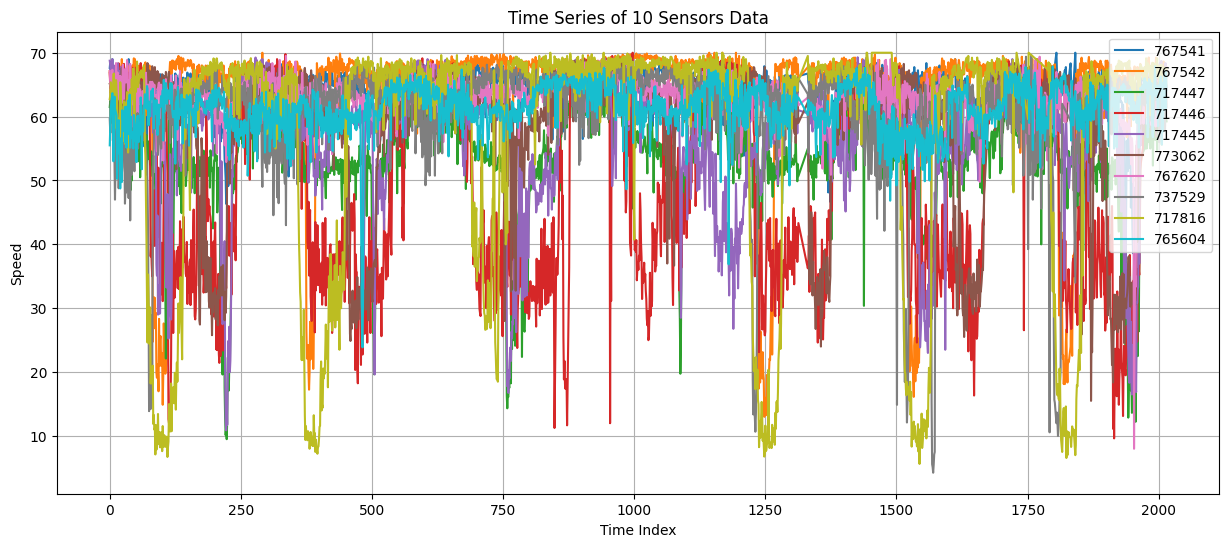

In [55]:
# YOUR CODE HERE
sensor_ids = df_speed.columns[1:11]

plt.figure(figsize=(15, 6))
for sensor_id in sensor_ids:
    plt.plot(df_speed.index, df_speed[sensor_id], label=sensor_id)

plt.title('Time Series of 10 Sensors Data')
plt.xlabel('Time Index')  # Using index as time representation
plt.ylabel('Speed')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

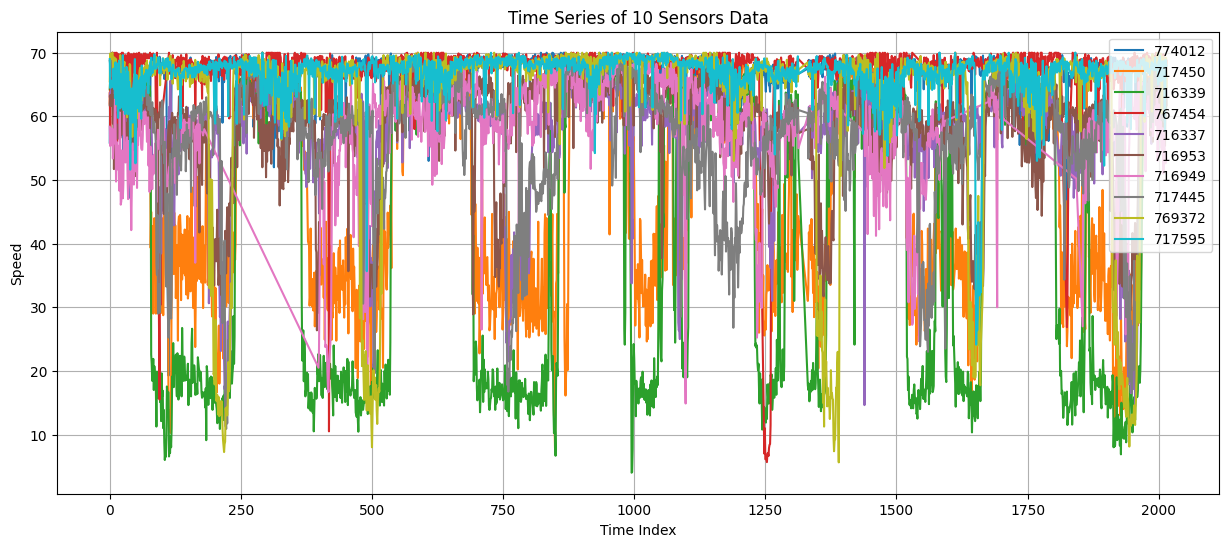

In [56]:
# YOUR CODE HERE
import random
sensor_ids = random.sample(list(df_speed.columns), 10)

plt.figure(figsize=(15, 6))
for sensor_id in sensor_ids:
    plt.plot(df_speed.index, df_speed[sensor_id], label=sensor_id)

plt.title('Time Series of 10 Sensors Data')
plt.xlabel('Time Index')  # Using index as time representation
plt.ylabel('Speed')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Create and draw the graph of adjacency of matrix

Hint: [link](https://towardsdatascience.com/graph-coloring-with-networkx-88c45f09b8f4)

In [57]:
colors = [
    "lightcoral", "gray", "lightgray", "firebrick", "red", "chocolate",
    "darkorange", "moccasin", "gold", "yellow", "darkolivegreen", "chartreuse",
    "forestgreen", "lime", "mediumaquamarine", "turquoise", "teal", "cadetblue",
    "dogerblue", "blue", "slateblue", "blueviolet", "magenta", "lightsteelblue"
]

def greedy_coloring_algorithm(network, colors):
    nodes = list(network.nodes())
    #random.shuffle(nodes)  # step 1 random ordering
    for node in nodes:
        dict_neighbors = dict(network[node])
        # gives names of nodes that are neighbors
        nodes_neighbors = list(dict_neighbors.keys())

        forbidden_colors = []
        for neighbor in nodes_neighbors:
            # Check if the neighbor has a color assigned
            if 'color' in network.nodes[neighbor]:
                forbidden_color = network.nodes[neighbor]['color']
                forbidden_colors.append(forbidden_color)

        # assign the first color that is not forbidden
        for color in colors:
            if color not in forbidden_colors:
                network.nodes[node]['color'] = color
                break

In [58]:
# YOUR CODE HERE
adj_matrix = df_adj.values  # Convert DataFrame to NumPy array
# Create a graph object from the adjacency matrix
graph = nx.from_numpy_array(adj_matrix)
greedy_coloring_algorithm(graph, colors)
colors_nodes = [data['color'] for v, data in graph.nodes(data=True)]

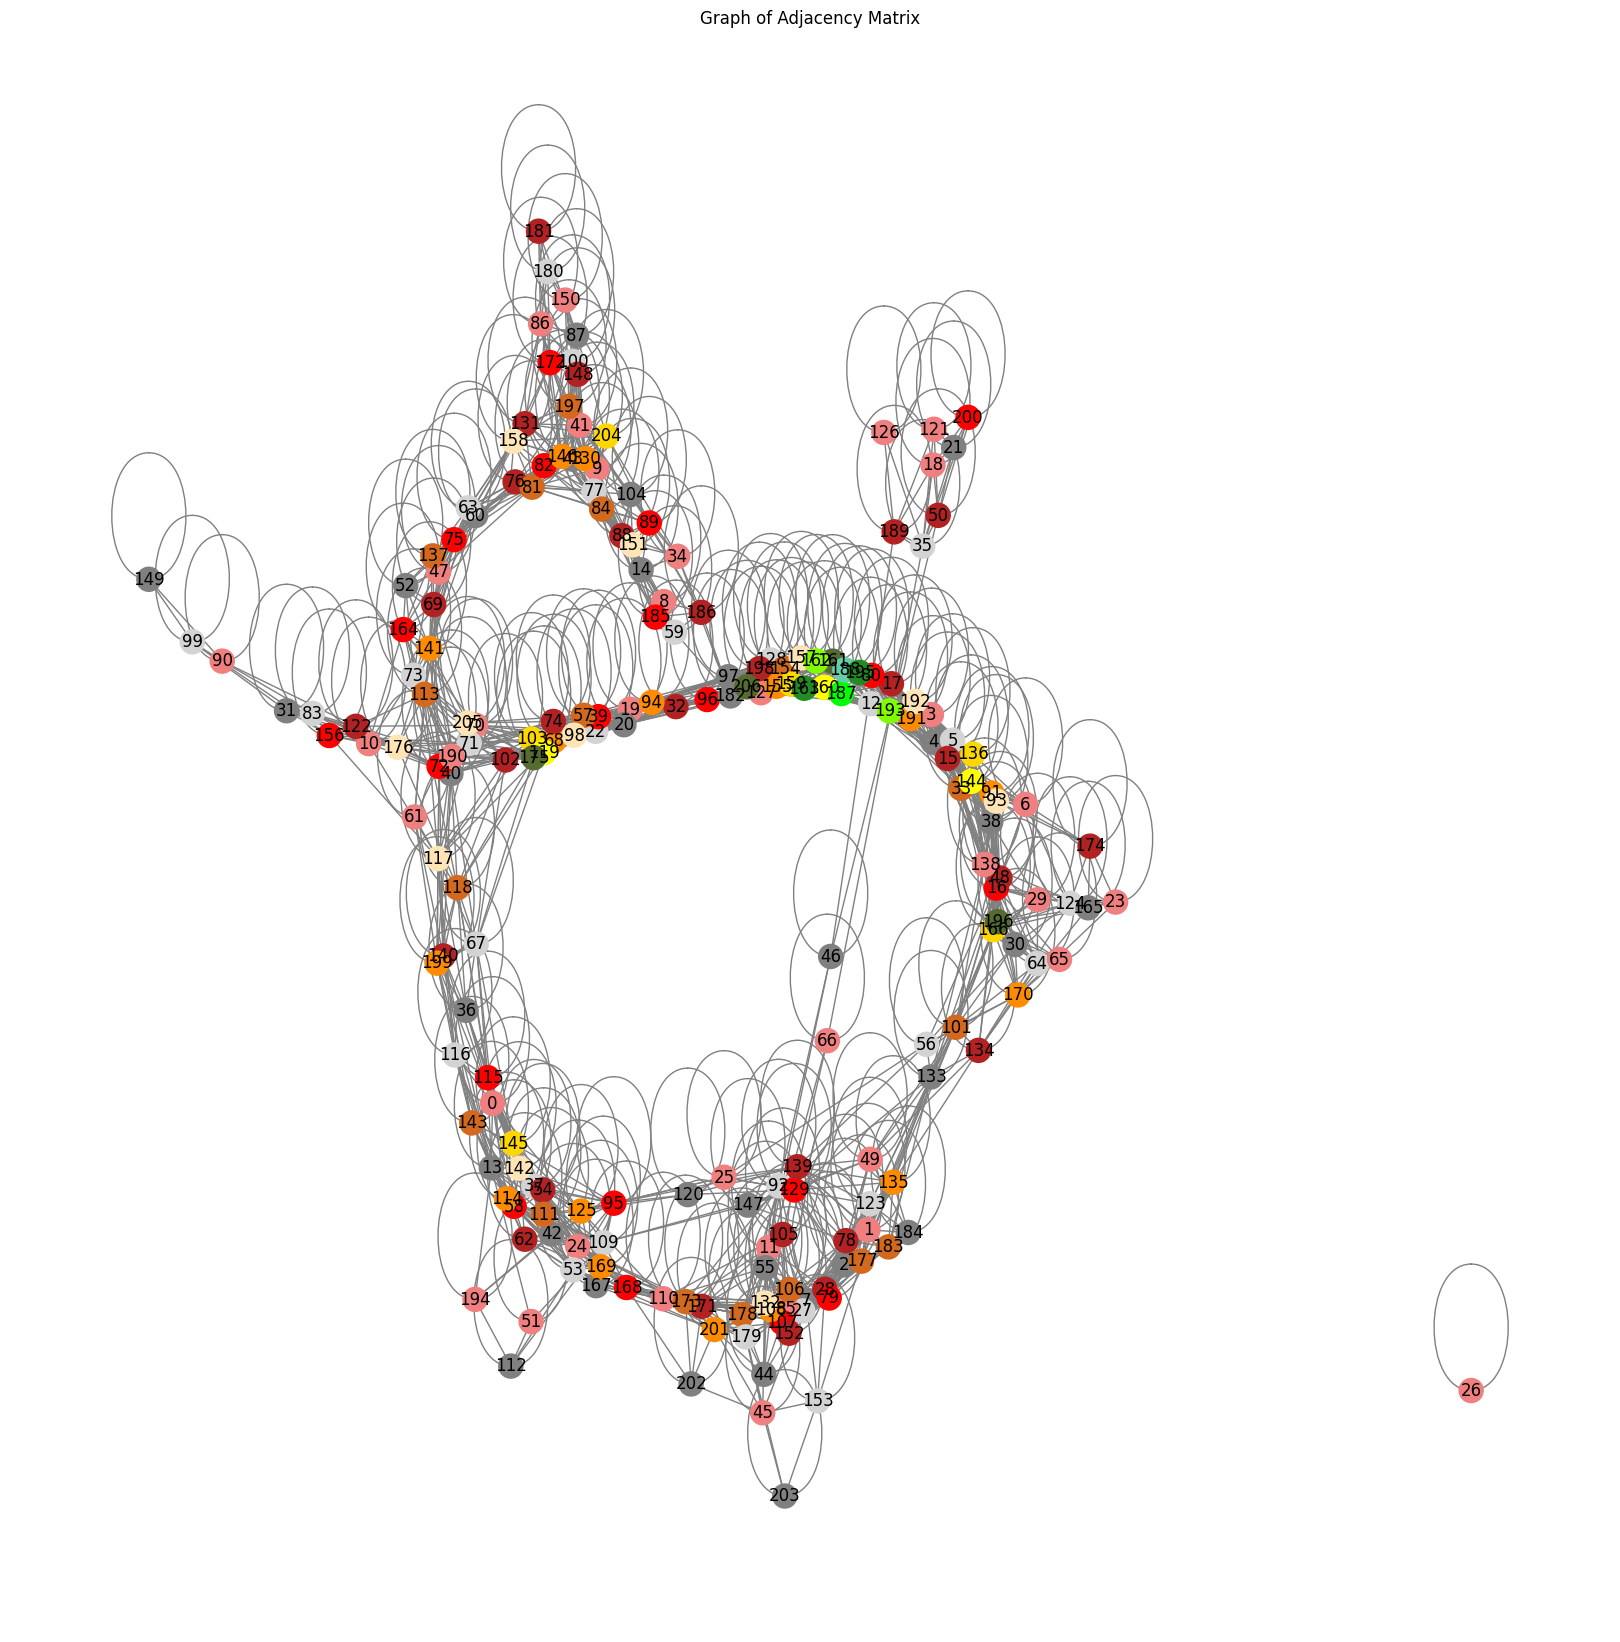

In [59]:
#Draw the graph
plt.figure(figsize=(16, 16))
nx.draw(graph, with_labels=True, node_color=colors_nodes, edge_color='gray')
plt.title("Graph of Adjacency Matrix")
plt.show()

In [60]:
!pip install plotly
import plotly.graph_objects as go
import networkx as nx

# Assuming you have already created the 'graph' object from df_adj
# (as you did in a previous step using nx.from_numpy_array)

# Get node positions (you might need to adjust the layout algorithm)
pos = nx.spring_layout(graph)

# Create edge trace
edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_x = []
node_y = []
node_text = []  # List to store node labels

for node in graph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(str(node))  # Convert node ID to string for label


node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',  # Add 'text' to the mode
    hoverinfo='text',
    marker=dict(
        size=10,
        line_width=2),
    text=node_text,  # Assign the node labels
    textposition='top center'  # Position the labels above the nodes
)

# Update node trace hover text if you have node attributes
# (e.g., sensor IDs)
node_text = [f'Sensor ID: {node}' for node in graph.nodes()]
node_trace.text = node_text

# Create the figure and add traces
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Sensor Network Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Show the interactive graph
fig.show()

#### Preprocessing and train test split

In [61]:
# YOUR CODE HERE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
# Step 1: Normalize the speed data
scaler = MinMaxScaler()
normalized_speed = scaler.fit_transform(df_speed)

# Convert normalized data back to a DataFrame for easier handling
normalized_speed_df = pd.DataFrame(normalized_speed, columns=df_speed.columns)

# Step 2: Train-test split
# Define a split ratio (e.g., 80% training, 20% testing)
train_data, test_data = train_test_split(normalized_speed_df, test_size=0.2, random_state=42, shuffle=False)

In [62]:
train_data.shape, test_data.shape

((1612, 207), (404, 207))

#### Prepare Time series data


Aim is to use 50 minutes of historical speed observations to predict the speed in future (1 hour ahead)

* Choose windows of 10 historical observations i.e. 5 * 10 = 50 minutes (`seq_len`) for each segment as the input and use it to predict the speed after 5 * 12 = 60 minutes (target) using the sliding window approach.

**Note:**
The below parameters
-  `seq_len` is the size of the past window of information.
- `pre_len` is future prediction ( 1 hour in future = 12 * 5 minutes)



Steps:

* Prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a **sequence of past observations as input to an output observation**, so the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

* Choose to use 50 minutes of historical speed observations to predict the speed in future (eg. 1 hour ahead). First reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later as the prediction label. This can be performed using a sliding window approach:

    - Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict.

    - Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict.

    - Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

  *Note: The above steps are done for each sensor.*

Define a function below to return the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

Each **training observation** is 10 historical speeds **(seq_len).**

Each **training prediction** is the speed 60 minutes later **(pre_len).**

In [63]:
seq_len = 10
pre_len = 12
# YOUR CODE HERE
import numpy as np

def prepare_time_series_data(data, seq_len, pre_len):
    """
    Prepares the time-series data for LSTM using a sliding window approach.

    Parameters:
        data (pd.DataFrame): DataFrame containing time-series data for multiple sensors.
        seq_len (int): Number of past time steps to use as input features.
        pre_len (int): Number of future time steps to predict.

    Returns:
        X (np.ndarray): Input features for training (shape: [samples, seq_len, sensors]).
        y (np.ndarray): Target labels for training (shape: [samples, sensors]).
    """
    data_array = data.values  # Convert DataFrame to NumPy array for efficient processing
    num_samples, num_sensors = data_array.shape
    X, y = [], []

    # Sliding window
    for i in range(num_samples - seq_len - pre_len + 1):
        X.append(data_array[i : i + seq_len])  # Input sequence of length seq_len
        y.append(data_array[i + seq_len + pre_len - 1])  # Target prediction at pre_len

    X = np.array(X)  # Convert to NumPy arrays
    y = np.array(y)
    return X, y


# Prepare the data
X, y = prepare_time_series_data(normalized_speed_df, seq_len, pre_len)

# Display the shapes of the prepared data
print("Input Feature Shape (X):", X.shape)
print("Target Shape (y):", y.shape)

Input Feature Shape (X): (1995, 10, 207)
Target Shape (y): (1995, 207)


### Build and Train the LSTM model and plot the loss results (3 points)

In [64]:
# YOUR CODE HERE
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, X.shape[2])),
    Dense(y.shape[1])  # Output layer with number of sensors as output size
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.4703 - val_loss: 0.0525
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0330 - val_loss: 0.0402
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0280 - val_loss: 0.0377
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0258 - val_loss: 0.0352
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0235 - val_loss: 0.0302
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0212 - val_loss: 0.0279
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0193 - val_loss: 0.0266
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0185 - val_loss: 0.0260
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0177 - val_loss: 0.0252
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0175 - val_loss: 0.0248
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172 - val_loss: 0.0246
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0172 - val_loss: 0.0243

In [65]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1596, 10, 207), (399, 10, 207), (1596, 207), (399, 207))

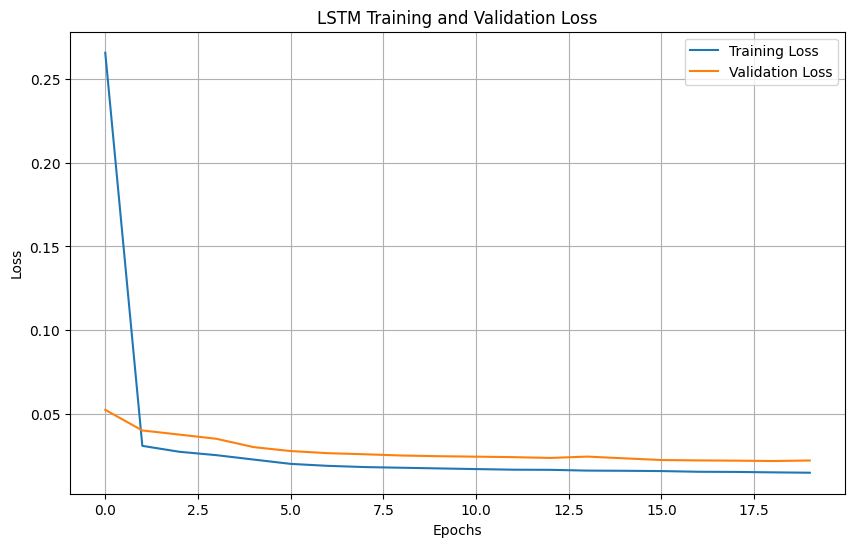

In [66]:
# YOUR CODE HERE to plot the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### StellarGraph Graph Convolution and LSTM model ( 3 points)

In order to use the model, we need:

* An **N by N** adjacency matrix, which describes the distance relationship between the N sensors,

* An **N by T** feature matrix, which describes the ($f_1, .., f_T$) speed records over T timesteps for the N sensors.

Arguments of GCN_LSTM:
  - seq_len: No. of LSTM cells

  - adj: unweighted/weighted adjacency matrix

  - gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.

  - lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.

  - gc_activations (list of str or func): Activations applied to each layer's output.

  - lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.

In [75]:
# Implement GCN-LSTM
# YOUR CODE HERE

In [76]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=adj_matrix,
    gc_layer_sizes=[64, 32],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[128, 64],
    lstm_activations=["tanh", "tanh"],
)

<ipython-input-76-0f8c5d721f9c>:1: ExperimentalWarning:

GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.



#### Rescale values
Rescale the predicted values to the original value range of the timeseries.

In [77]:
# YOUR CODE HERE
# Build the Keras


### Plot the predictions and Loss of each sensor ( 2 points)

* Select any one sensor's prediction and plot the graph.

In [78]:
# YOUR CODE HERE

#### Plot error (MAE and MSE) for all the sensors

In [ ]:
# YOUR CODE HERE

#### Report Analysis

  * Discuss: Why is this called a spatio-temporal problem?

  * Discuss: In what way is GCN-LSTM more useful for the traffic prediction task than LSTM?